In [1]:
library(ggplot2)
library(Deriv)
library(orthopolynom)

In [2]:
rangexp=function(u,n=10){
  n*exp(-u)*((1-exp(-u))^(n-1))
}

f <- function(x) {
  rangexp(x, n = n_val)
}

In [3]:
#---Sample generator---
rangesamp=function(m,n=10){
  mat=matrix(rexp(m*(n+1),rate=1),nr=m)
  return(apply(mat,MARGIN = 1,FUN = function(x){return(max(x)-min(x))}))
}

# Kernel Density Estimation

In [4]:
x <- rangesamp(m = 500)
bw_ls <- bw.ucv(x)
dens <- density(x, bw = bw_ls, kernel = "gaussian")

# Create a data frame for the kernel density estimate
df_kernel <- data.frame(x = dens$x, density = dens$y)

In [5]:
# Create a grid for the exact density and compute it using rangexp
grid_x <- seq(0, 10, length.out = 1000)
df_exact <- data.frame(x = grid_x, density = rangexp(grid_x))

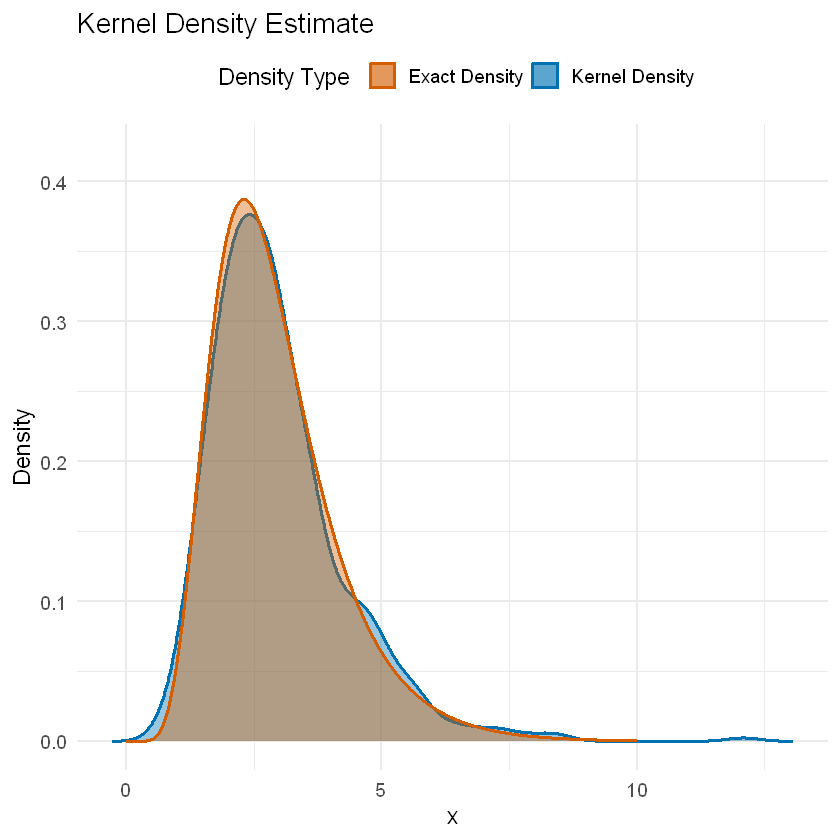

In [6]:
# Build the ggplot with filled areas, matching borders, and legend on top
p <- ggplot() +
  geom_area(data = df_kernel, 
            aes(x = x, y = density, fill = "Kernel Density", color = "Kernel Density"), 
            alpha = 0.4, linewidth = 1) +
  geom_area(data = df_exact, 
            aes(x = x, y = density, fill = "Exact Density", color = "Exact Density"), 
            alpha = 0.4, linewidth = 1) +
  scale_fill_manual(name = "Density Type",
                    values = c("Kernel Density" = "#0072B2", 
                               "Exact Density" = "#D55E00")) +
  scale_color_manual(name = "Density Type",
                     values = c("Kernel Density" = "#0072B2", 
                                "Exact Density" = "#D55E00")) +
  labs(title = "Kernel Density Estimate",
       x = "x", y = "Density") +
  coord_cartesian(ylim = c(0, 0.42)) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "top")

print(p)

# Edgeworth Expansions

In [7]:
#--Edgeworth Expansions--
# Define the Hermite function
hermite_eval <- function(order, x, type = c("probabilists", "physicists"), normalized = FALSE) {
  type <- match.arg(type)
  if (order < 0 || order != floor(order)) {
    stop("Order must be a nonnegative integer")
  }
  
  # Generate the polynomials up to the specified order.
  # The list will contain polynomials from order 0 to 'order'.
  if (type == "probabilists") {
    polys <- hermite.he.polynomials(n = order, normalized = normalized)
  } else {
    polys <- hermite.h.polynomials(n = order, normalized = normalized)
  }
  
  # Evaluate each polynomial at the point(s) x.
  # The polynomial of the desired order is at index order + 1.
  eval_list <- polynomial.values(polynomials = polys, x = x)
  result <- eval_list[[order + 1]]
  return(result)
}

#-A function for calculating derivatives--
cgf=function(t,n=10){
  return(sum(sapply(1:n,FUN = function(j){-log(1-(t/j))})))
}

cgfk=function(t,k,n=10){
  return(factorial(k-1)*mean(sapply(1:n,FUN = function(j){1/((j-t)^k)})))
}

In [8]:
den.edge <- function(y, n = 10) {
  # Compute location and scale adjustments
  mun <- sum(sapply(1:n, function(j) { 1/j }))
  sigman <- sqrt(sum(sapply(1:n, function(j) { 1/(j^2) })))
  
  # Standardize input y
  z <- (y - mun) / sigman
  
  # Cumulant generating function helper
  #K
  cgfk <- function(t, k) {
    factorial(k - 1) * mean(sapply(1:n, function(j) { (j - t)^(-k) }))
  }
  
  # Standardized cumulant estimator rho
  rho <- function(r) {
    cgfk(t = 0, k = r) / (cgfk(t = 0, k = 2)^(r / 2))
  }
  
  # Evaluate probabilists' Hermite polynomials at z
  H3 <- hermite_eval(order = 3, x = z, type = "probabilists")
  H4 <- hermite_eval(order = 4, x = z, type = "probabilists")
  H6 <- hermite_eval(order = 6, x = z, type = "probabilists")
  
  # Compute the density with Edgeworth expansion correction
  result <- dnorm(z) * (1 + (rho(3) * H3 / (6 * sqrt(n))) +
                          (rho(4) * H4 / (24 * n)) +
                          ((rho(3)^2) * H6 / (72 * n))) / sigman
  
  # Replace negative values with 0
  result <- pmax(result, 0)
  
  return(result)
}

In [9]:
# Set parameter value and grid
n_val <- 10
gridp <- seq(0, 10, length.out = 10000)

# Compute densities:
df_edge <- data.frame(
  x = gridp,
  density = den.edge(gridp, n = n_val),
  Method = "Edgeworth Expansion"
)

df_exact <- data.frame(
  x = gridp,
  density = rangexp(gridp, n = n_val),
  Method = "Exact Density"
)

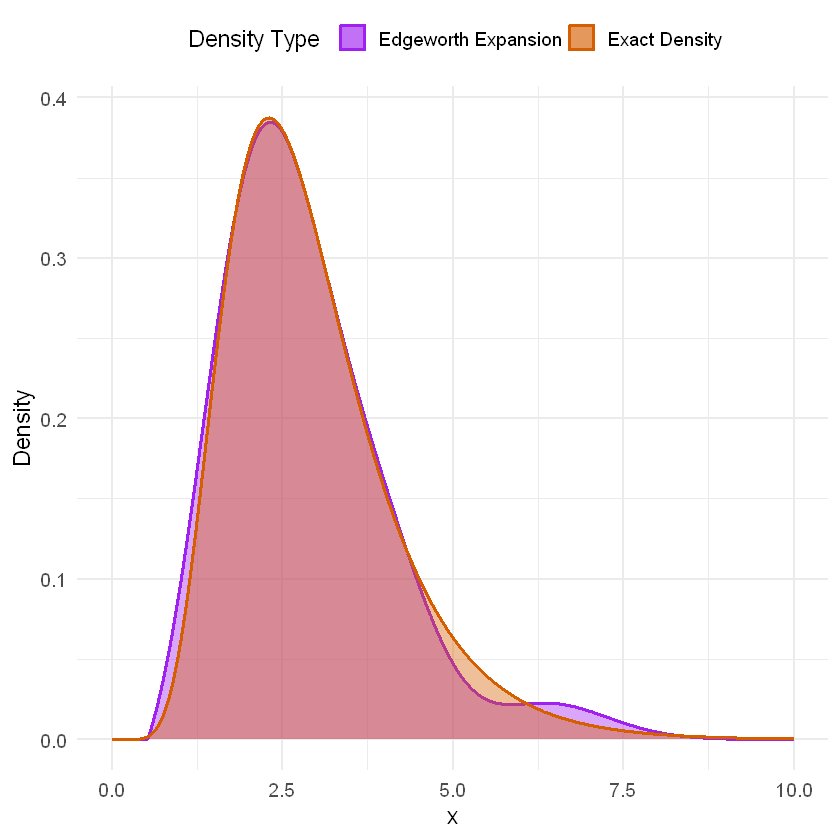

In [10]:
# Build the ggplot with filled areas and matching borders
p <- ggplot() +
  geom_area(data = df_edge, 
            aes(x = x, y = density, fill = "Edgeworth Expansion", color = "Edgeworth Expansion"),
            alpha = 0.4, linewidth = 1) +
  geom_area(data = df_exact, 
            aes(x = x, y = density, fill = "Exact Density", color = "Exact Density"),
            alpha = 0.4, linewidth = 1) +
  scale_fill_manual(name = "Density Type",
                    values = c("Edgeworth Expansion" = "purple",
                               "Exact Density" = "#D55E00")) +
  scale_color_manual(name = "Density Type",
                     values = c("Edgeworth Expansion" = "purple",
                                "Exact Density" = "#D55E00")) +
  labs(x = "x", y = "Density") +
  theme_minimal(base_size = 14) +
  theme(legend.position = "top")

print(p)